In [171]:
import os
import numpy as np 
import pandas as pd 
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GroupShuffleSplit


from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from typing import Any, Dict, Union

from yellowbrick import model_selection as ms
from yellowbrick.model_selection import validation_curve

from sklearn import metrics

from xgboost import XGBClassifier

from boruta import BorutaPy
from BorutaShap import BorutaShap, load_data
from sklearn.model_selection import train_test_split

In [172]:

all_train_ids =  ['S7072', 'S7083','S7070', 'S7096', 'S7091', 'S7094', 'S7075', 'S7071','S7101', 'S7088'] 
all_test_ids = ['S7086', 'S7069', 'S7076', 'S7092', 'S7071'] 

train_ids = [ 'S7072', 'S7083','S7070', 'S7096', 'S7091', 'S7094', 'S7075', 'S7071','S7101', 'S7088'] 
test_ids = ['S7086', 'S7069','S7076', 'S7092', 'S7071'] 
all_training_ids = ['S7072', 'S7083','S7070', 'S7096', 'S7091', 'S7094', 'S7075', 'S7071','S7101', 'S7088',
                   'S7086', 'S7069','S7076', 'S7092', 'S7071']


gap_ids = ['S7063', 'S7064', 'S7069', 'S7072', 'S7075', 'S7076', 'S7088', 'S7092', 'S7094', 'S7096']
wt_ids = ['S7068', 'S7070', 'S7071', 'S7074', 'S7083', 'S7086', 'S7091', 'S7098', 'S7101']

all_ids = ['S7068', 'S7070', 'S7071', 'S7074', 'S7086', 'S7091', 'S7098', 'S7101',
          'S7063', 'S7064', 'S7069', 'S7072', 'S7075', 'S7076', 'S7088', 'S7092', 'S7094', 'S7096']

def determine_genotype(animal_id, wt_ids, gap_ids):
    if animal_id in wt_ids:
        return 0  # WT
    elif animal_id in gap_ids:
        return 1  # GAP
    else:
        return None  # In case the ID is not found in either list


In [182]:
og_cv = pd.read_csv('/home/melissa/RESULTS/FINAL_MODEL/Rat/' +  'rat_xgboost_clean_indices.csv')
# Apply the function to each row in the DataFrame and ensure the type is integer
og_cv['Genotype'] = og_cv['Animal_ID'].apply(lambda x: determine_genotype(x, wt_ids, gap_ids)).astype('Int64')

og_cv.drop(['Unnamed: 0'], axis = 1, inplace = True) # 'Animal_ID.1'], axis = 1, inplace = True)

# Move 'Genotype' column to the first position
cols = og_cv.columns.tolist()
cols.insert(0, cols.pop(cols.index('Genotype')))
og_cv = og_cv[cols]

In [183]:
for idx in all_ids:
    if idx not in all_training_ids:
        print(idx)

S7068
S7074
S7098
S7063
S7064


In [184]:
all_train_ids =  ['S7094', 'S7092', 'S7071', 'S7101', 'S7083', 'S7063', 'S7064', 'S6069', 'S7091',
                 'S7070', 'S7072'] 
all_test_ids = ['S7088', 'S7076', 'S7068', 'S7086'] 

In [185]:
train_cv = og_cv[og_cv['Animal_ID'].isin(all_train_ids)]
test_cv = og_cv[og_cv['Animal_ID'].isin(all_test_ids)]
clean_train = train_cv.dropna()
clean_test = test_cv.dropna()

In [186]:
np.unique(og_cv['Animal_ID'])

array(['S7063', 'S7064', 'S7068', 'S7069', 'S7070', 'S7071', 'S7072',
       'S7074', 'S7075', 'S7076', 'S7083', 'S7086', 'S7088', 'S7091',
       'S7092', 'S7094', 'S7098', 'S7101'], dtype=object)

In [187]:
X_train = clean_train #.iloc[:, 3:]
y_train = clean_train.iloc[:, 0]

oversample = RandomOverSampler(sampling_strategy = 'minority')
X_train_res, y_train_res = oversample.fit_resample(X_train, y_train)

In [188]:
X_train_borut = X_train_res.iloc[:, 3:]
X_train_borut

,Mot_Disp,Som_Disp,Vis_Disp,Mot_HFD,Som_HFD,Vis_HFD,Mot_Hurst,Som_Hurst,Vis_Hurst,Mot_CC_Delta,...,Som_Delta,Som_Theta,Som_Sigma,Som_Beta,Som_Gamma,Vis_Delta,Vis_Theta,Vis_Sigma,Vis_Beta,Vis_Gamma
0,2.661363,2.785862,2.150858,1.289230,1.459179,1.339925,0.533680,0.699312,0.831409,0.871219,...,166.944585,20.082098,3.904823,1.405361,0.333971,166.944585,20.082098,3.904823,1.405361,0.333971
1,2.429339,2.654425,2.318230,1.253846,1.418100,1.299268,0.544955,0.669769,0.667256,0.941749,...,302.874196,56.461881,10.696398,1.874631,0.363133,302.874196,56.461881,10.696398,1.874631,0.363133
2,2.754251,2.773382,2.462278,1.273213,1.417891,1.288588,0.561474,0.679757,0.672432,0.809575,...,171.427417,65.809293,19.023742,4.268766,0.709685,171.427417,65.809293,19.023742,4.268766,0.709685
3,2.800803,2.731877,2.457211,1.219245,1.392334,1.272185,0.415850,0.672158,0.671363,0.882261,...,159.190548,66.017250,8.800330,3.963223,1.108411,159.190548,66.017250,8.800330,3.963223,1.108411
4,3.240615,2.663132,2.397300,1.367765,1.318986,1.354022,0.575055,0.788821,0.930522,0.726963,...,26.579474,14.479776,4.568109,1.505296,0.446227,26.579474,14.479776,4.568109,1.505296,0.446227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22447,0.284662,0.284662,0.284662,1.505846,1.504243,1.502571,0.895612,0.878138,0.836619,0.999200,...,73566.768862,275.862497,90.222911,32.728089,11.930772,73566.768862,275.862497,90.222911,32.728089,11.930772
22448,2.579302,2.530587,2.403782,1.242170,1.242598,1.242235,0.590838,0.595646,0.643357,0.971898,...,593.363023,74.768072,43.255573,6.656826,0.897094,593.363023,74.768072,43.255573,6.656826,0.897094
22449,2.294439,2.267643,2.252156,1.199797,1.221212,1.243482,0.523265,0.520043,0.628489,0.983459,...,1363.364649,71.642821,20.426576,4.208168,0.839289,1363.364649,71.642821,20.426576,4.208168,0.839289
22450,2.274338,2.241606,2.234135,1.181730,1.195838,1.190313,0.506891,0.545085,0.563672,0.978919,...,1229.153694,85.510288,12.160419,2.269096,0.530541,1229.153694,85.510288,12.160419,2.269096,0.530541


In [189]:
X_train_res.select_dtypes(include=['object', 'category']).columns

Index(['Animal_ID'], dtype='object')

In [190]:
estimator_borutashap=XGBClassifier(n_jobs = -1,
                                           random_state=42,
                                           max_depth=4)
borutashap = BorutaShap(model = estimator_borutashap,
                            importance_measure = 'shap',
                            classification = True)
borutashap.fit(X = X_train_borut, y = y_train_res, 
                   n_trials = 500)

  0%|          | 0/500 [00:00<?, ?it/s]

28 attributes confirmed important: ['Mot_Disp', 'Vis_HFD', 'Mot_HFD', 'Mot_CC_Beta', 'Mot_CC_Theta', 'Mot_CC_Sigma', 'Som_Disp', 'Som_CC_Theta', 'Som_CC_Sigma', 'Mot_Hurst', 'Vis_Disp', 'Vis_CC_Delta', 'Mot_Theta', 'Mot_CC_Delta', 'Vis_CC_Theta', 'Som_HFD', 'Mot_Delta', 'Som_CC_Beta', 'Som_CC_Delta', 'Vis_CC_Gamma', 'Mot_Gamma', 'Mot_CC_Gamma', 'Vis_CC_Beta', 'Vis_Hurst', 'Vis_CC_Sigma', 'Mot_Beta', 'Som_CC_Gamma', 'Som_Hurst']
11 attributes confirmed unimportant: ['Vis_Beta', 'Som_Theta', 'Vis_Gamma', 'Vis_Theta', 'Som_Beta', 'Vis_Sigma', 'Vis_Delta', 'Som_Sigma', 'Som_Delta', 'Mot_Sigma', 'Som_Gamma']
0 tentative attributes remains: []


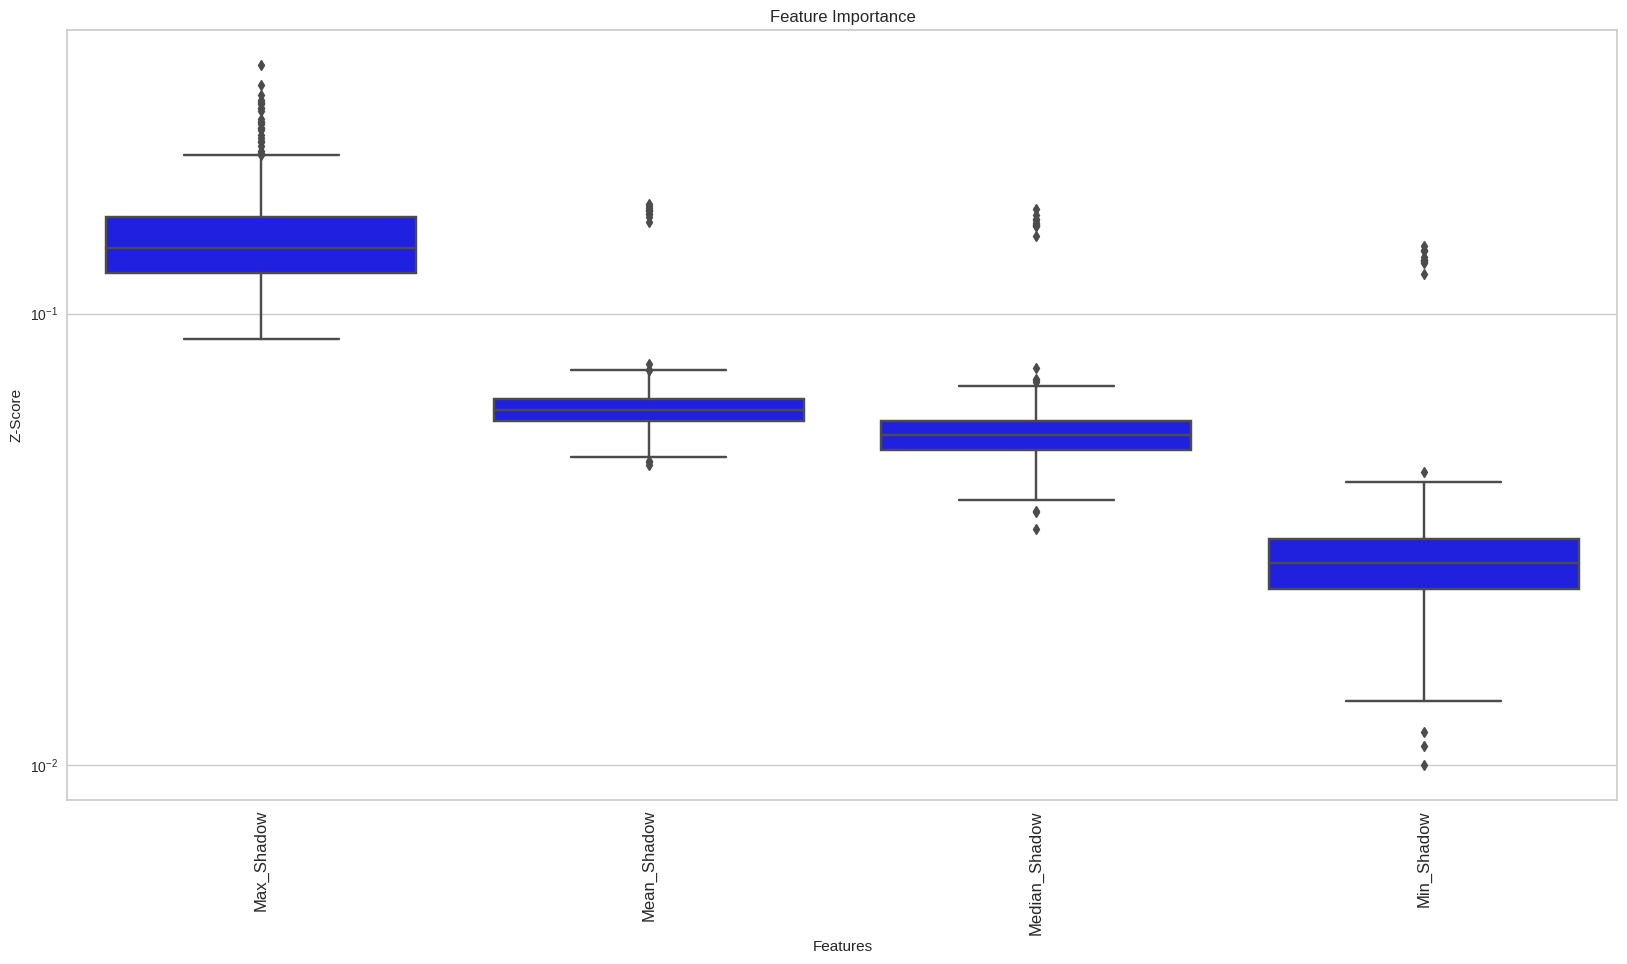

In [193]:
borutashap.plot(X_size=12, figsize=(20,10),
            y_scale='log', which_features='tentative')

In [194]:
features = ['Genotype', 'Animal_ID', 'Mot_Disp', 'Vis_HFD', 'Mot_HFD', 
            'Mot_CC_Beta', 'Mot_CC_Theta', 'Mot_CC_Sigma', 'Som_Disp', 
            'Som_CC_Theta', 'Som_CC_Sigma', 'Mot_Hurst', 'Vis_Disp',
            'Vis_CC_Delta', 'Mot_Theta', 'Mot_CC_Delta', 'Vis_CC_Theta', 
            'Som_HFD', 'Mot_Delta', 'Som_CC_Beta', 'Som_CC_Delta', 'Vis_CC_Gamma',
            'Mot_Gamma', 'Mot_CC_Gamma', 'Vis_CC_Beta', 'Vis_Hurst',
            'Vis_CC_Sigma', 'Mot_Beta', 'Som_CC_Gamma', 'Som_Hurst']

In [195]:
new_df = og_cv[features]
clean_df = new_df.dropna()

In [196]:
print(len(new_df))
print(len(clean_df))

23562
23562


In [245]:
all_train_ids =  ['S7071', 'S7068', 'S7091',  'S7092', 'S7063', 'S7088', 'S7101', 'S7064', 'S7083',
                  'S7070',  'S7072', 'S7069', 'S7094'] 
all_test_ids = [ 'S7086', 'S7076'] 
X_train = clean_df[clean_df["Animal_ID"].isin(all_train_ids)]
X_test = clean_df[clean_df["Animal_ID"].isin(all_test_ids)]
y_train = X_train.iloc[:, 0]
y_test = X_test.iloc[:, 0]

oversample = RandomOverSampler(sampling_strategy = 'minority')
X_train_res, y_train_res = oversample.fit_resample(X_train, y_train)
X_test_res, y_test_res = oversample.fit_resample(X_test, y_test)
X_test_new = X_test_res.iloc[:, 2:]

In [246]:
X_train_res.loc[X_train_res['Genotype'] == 0]

,Genotype,Animal_ID,Mot_Disp,Vis_HFD,Mot_HFD,Mot_CC_Beta,Mot_CC_Theta,Mot_CC_Sigma,Som_Disp,Som_CC_Theta,...,Som_CC_Delta,Vis_CC_Gamma,Mot_Gamma,Mot_CC_Gamma,Vis_CC_Beta,Vis_Hurst,Vis_CC_Sigma,Mot_Beta,Som_CC_Gamma,Som_Hurst
2814,0,S7068,2.468089,1.531774,1.541066,0.848314,0.774044,0.804200,2.317283,0.981321,...,0.987070,0.932837,1.590701,0.850342,0.967545,0.956093,0.985163,3.047907,0.947320,0.960286
2815,0,S7068,2.893370,1.571178,1.534789,0.845013,0.792929,0.746965,3.106194,0.968799,...,0.936095,0.914819,1.239615,0.873502,0.920444,0.843990,0.946740,2.858681,0.942462,0.763035
2816,0,S7068,3.387668,1.630894,1.609143,0.728313,0.679914,0.690163,3.313063,0.935620,...,0.888235,0.910337,1.837932,0.816964,0.918190,0.857902,0.929906,3.051095,0.921896,0.826141
2817,0,S7068,2.821895,1.497572,1.507213,0.925695,0.821628,0.865985,3.172519,0.941040,...,0.568652,0.842836,1.227895,0.917124,0.817868,0.838324,0.767268,4.260388,0.944737,0.774473
2818,0,S7068,2.742142,1.400728,1.445103,0.946045,0.945062,0.947437,2.746773,0.775892,...,0.302195,0.760226,1.034490,0.917617,0.831080,0.823222,0.857043,3.822639,0.861524,0.754604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17179,0,S7070,2.697589,1.217545,1.189519,0.901827,0.901827,0.932957,2.628161,0.906951,...,0.888075,0.771881,0.553591,0.861215,0.790563,0.584577,0.841125,4.298255,0.895548,0.529781
17180,0,S7070,2.709844,1.236996,1.204034,0.882920,0.882920,0.939780,2.532549,0.933934,...,0.727036,0.741546,0.477137,0.869099,0.806864,0.571391,0.862961,3.138379,0.884300,0.628065
17181,0,S7070,2.688676,1.198197,1.195954,0.923766,0.923766,0.929065,2.643587,0.912500,...,0.796079,0.683754,0.554141,0.885860,0.821708,0.622637,0.828591,5.050128,0.902580,0.482634
17182,0,S7070,2.411849,1.223193,1.195731,0.934518,0.934518,0.961750,2.363734,0.921722,...,0.914187,0.696504,0.560939,0.874897,0.796871,0.704171,0.906420,2.872414,0.869240,0.604527


In [247]:
X_train_res.loc[X_train_res['Genotype'] == 1]

,Genotype,Animal_ID,Mot_Disp,Vis_HFD,Mot_HFD,Mot_CC_Beta,Mot_CC_Theta,Mot_CC_Sigma,Som_Disp,Som_CC_Theta,...,Som_CC_Delta,Vis_CC_Gamma,Mot_Gamma,Mot_CC_Gamma,Vis_CC_Beta,Vis_Hurst,Vis_CC_Sigma,Mot_Beta,Som_CC_Gamma,Som_Hurst
0,1,S7088,2.924756,1.323589,1.246898,0.930179,0.961686,0.946573,2.837509,0.922718,...,0.689940,0.911559,1.460645,0.936827,0.927070,0.623940,0.962157,3.948171,0.833637,0.570216
1,1,S7088,3.207341,1.517581,1.563359,0.898779,0.884031,0.897554,2.660240,0.636551,...,0.304594,0.838220,0.988153,0.889056,0.836890,0.989110,0.864725,1.448138,0.536941,0.825178
2,1,S7088,3.283838,1.567093,1.660008,0.939125,0.902661,0.891006,2.774685,0.651716,...,0.467333,0.845093,1.543682,0.907686,0.859491,0.791040,0.739141,2.125094,0.635932,0.802828
3,1,S7088,2.401398,1.330193,1.267942,0.904080,0.961692,0.934196,2.440441,0.926134,...,0.871677,0.854509,0.628882,0.882807,0.910306,0.720987,0.952582,2.296411,0.714693,0.714052
4,1,S7088,2.512448,1.312921,1.232919,0.934285,0.973333,0.941545,2.552856,0.958312,...,0.925948,0.832293,0.569876,0.902207,0.877844,0.723520,0.893251,5.809671,0.669548,0.637532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23035,1,S7072,2.664694,1.231319,1.219190,0.933361,0.933361,0.937846,2.592990,0.971325,...,0.978254,0.870986,1.353668,0.857192,0.943259,0.606188,0.954977,16.222387,0.933259,0.543721
23036,1,S7092,2.522437,1.282304,1.263221,0.927802,0.952539,0.952425,2.617958,0.885887,...,0.627880,0.807982,0.497249,0.892440,0.905368,0.803150,0.934571,1.641824,0.593867,0.687756
23037,1,S7072,2.364973,1.251674,1.205192,0.916464,0.916464,0.929532,2.424931,0.934672,...,0.980766,0.875654,0.325141,0.821963,0.904363,0.604628,0.920835,2.064913,0.895842,0.538680
23038,1,S7092,3.436677,1.523897,1.578555,0.910802,0.861461,0.854478,2.632893,0.590654,...,0.397553,0.856052,0.600733,0.856412,0.859044,0.949590,0.916284,1.995334,0.515314,0.840316


In [264]:
X_train_new = X_train_res.iloc[:, 2:]

In [249]:
group_by_patient_id = X_train_res.groupby(['Animal_ID'])
groups_by_patient_id_list = np.array(X_train_res['Animal_ID'].values)
groups_by_patient_id_list

array(['S7088', 'S7088', 'S7088', ..., 'S7072', 'S7092', 'S7092'],
      dtype=object)

In [236]:
n_splits = 3
group_kfold = GroupKFold(n_splits = n_splits)
print(group_kfold.get_n_splits(X_train_new, y_train_res, groups = groups_by_patient_id_list))

result = []
y_result = []
for train_idx, val_idx in group_kfold.split(X_train_new, y_train_res, groups = groups_by_patient_id_list):
    train_fold = X_train_new.iloc[train_idx]
    val_fold = X_train_new.iloc[val_idx]
    train_y_fold = y_train_res.iloc[train_idx]
    val_y_fold = y_train_res.iloc[val_idx]
    result.append((train_fold, val_fold))
    y_result.append((train_y_fold, val_y_fold))
    
train_fold_1, val_fold_1 = result[0][0],result[0][1]
train_fold_2, val_fold_2 = result[1][0],result[1][1]
train_fold_3, val_fold_3 = result[2][0],result[2][1]


y_train_fold_1, y_val_fold_1 = y_result[0][0],y_result[0][1]
y_train_fold_2, y_val_fold_2 = y_result[1][0],y_result[1][1]
y_train_fold_3, y_val_fold_3 = y_result[2][0],y_result[2][1]

3


In [250]:
options = {'max_depth': hp.quniform('max_depth', 1, 8, 1), #tree
            'min_child_weight': hp.loguniform('min_child_weight', -2, 3),
            'subsample': hp.uniform('subsample', 0.5, 1), #stochastic
            'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
            'reg_alpha': hp.uniform('reg_alpha', 0, 10), 
            'reg_lambda': hp.uniform('reg_lambda', 1, 10),
            'gamma': hp.loguniform('gamma', -10, 10),
            'learning_rate': hp.loguniform('learning_rate', -7, 0), 
            'random_state': 2
          }

In [251]:
def hyperparameter_tuning(space: Dict[str, Union[float, int]],
                         X_train: pd.DataFrame, y_train: pd.Series, 
                         X_test: pd.DataFrame, y_test: pd.Series, 
                         early_stopping_rounds: int = 50, 
                         metric: callable = roc_auc_score) -> Dict[str, Any]:
    
    '''Perform hyperparameter runing for an XGBoost classifier. 
    
    This function takes a dictionary of hyperparameters, training and test data, and an optional value
    for early stopping rounds, and returns a dictionary with the loss and model resulting from 
    the tuning process. The model is trained using the training data and evaluated on the test 
    data. The loss is computed as the negative of the accuracy score.
    
    space: Dict[str, Union[float, int]]
    A dictionary of hyperparameters for the XGBoost classifier
    
    X_train: pd.DataFrame
    The training data
    
    y_train: pd.Series
    The training target
    
    X_test: pd.Dataframe
    The test data
    
    y_test: pd.Series
    The test target
    
    early_stopping rounds: int, optional 
    The number of early stopping rounds to use. The deault is 50
    
    metric: callable
    Metric to maximise. Default is accuracy
    
    Returns: 
    Dict[str, Any]
        A dictionary with the loss and model resulting from the tuning process. 
        The loss is a float, and the model is an XGBoost classifier'''
    
    int_vals = ['max_depth', 'reg_alpha']
    
    space = {k: (int(val) if k in int_vals else val)
            for k, val in space.items()}
    
    space['early_stopping_rounds'] = early_stopping_rounds
    
    model = xgb.XGBClassifier(**space)
    evaluation = [(X_train, y_train), 
                 (X_test, y_test)]
    model.fit(X_train, y_train, eval_set = evaluation, verbose = False)
    
    score = metrics.roc_auc_score(y_test, model.predict(X_test))
    return {'loss': -score, 'status': STATUS_OK, 'model': model}

In [252]:
trials = Trials()
best_1 = fmin(fn = lambda space: hyperparameter_tuning(space, X_train = train_fold_1, y_train = y_train_fold_1,
                                                     X_test = val_fold_1, y_test = y_val_fold_1),
            space = options,
            algo = tpe.suggest,
            max_evals = 100,
            trials = trials)

100%|███████| 100/100 [00:32<00:00,  3.04trial/s, best loss: -0.738402001210593]


In [253]:
best_1

{'colsample_bytree': 0.6209680507557443,
 'gamma': 1639.3477989922878,
 'learning_rate': 0.18730043370876984,
 'max_depth': 1.0,
 'min_child_weight': 0.5011676509613924,
 'reg_alpha': 2.5404553522098174,
 'reg_lambda': 1.5446983285479738,
 'subsample': 0.8866504578796559}

In [254]:
trials = Trials()
best_2 = fmin(fn = lambda space: hyperparameter_tuning(space, X_train = train_fold_2, y_train = y_train_fold_2,
                                                     X_test = val_fold_2, y_test = y_val_fold_2),
            space = options,
            algo = tpe.suggest,
            max_evals = 100,
            trials = trials)

100%|██████| 100/100 [00:28<00:00,  3.45trial/s, best loss: -0.8537461774238264]


In [242]:
best_2

{'colsample_bytree': 0.5290850327180321,
 'gamma': 0.0001460284442936826,
 'learning_rate': 0.5814438491118862,
 'max_depth': 1.0,
 'min_child_weight': 0.24334861504536942,
 'reg_alpha': 5.986997824876159,
 'reg_lambda': 1.4665208209606782,
 'subsample': 0.6151436158918928}

In [243]:
trials = Trials()
best_3 = fmin(fn = lambda space: hyperparameter_tuning(space, X_train = train_fold_3, y_train = y_train_fold_3,
                                                     X_test = val_fold_3, y_test = y_val_fold_3),
            space = options,
            algo = tpe.suggest,
            max_evals = 100,
            trials = trials)

100%|██████| 100/100 [00:32<00:00,  3.03trial/s, best loss: -0.5868710143623542]


In [244]:
best_3

{'colsample_bytree': 0.5082014657385654,
 'gamma': 0.0006493300668346067,
 'learning_rate': 0.0014517208890401391,
 'max_depth': 5.0,
 'min_child_weight': 0.2932810767461162,
 'reg_alpha': 4.281686881744247,
 'reg_lambda': 8.612082084431767,
 'subsample': 0.5039670850215741}

In [260]:
best_previous = {'colsample_bytree': 0.5640125501892845,
 'gamma': 886.1540988328427,
 'learning_rate': 0.07054345778305847,
 'max_depth': 4,
 'min_child_weight': 2.637224503774358,
 'reg_alpha': 4.604438973488756,
 'reg_lambda': 3.1664179220499076,
 'subsample': 0.6401529750159931}

In [256]:
best_2 = {'colsample_bytree': 0.5290850327180321,
 'gamma': 0.0001460284442936826,
 'learning_rate': 0.5814438491118862,
 'max_depth': 4,
 'min_child_weight': 0.24334861504536942,
 'reg_alpha': 5.986997824876159,
 'reg_lambda': 1.4665208209606782,
 'subsample': 0.6151436158918928}

In [261]:
best_model = xgb.XGBClassifier(**best_previous)
best_model.fit(X_train_new, y_train_res)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5640125501892845, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=886.1540988328427, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.07054345778305847, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=2.637224503774358, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [265]:
best_model.score(X_test_new, y_test_res)

0.06298449612403101